In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from scipy.spatial import distance
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [4]:
dataset = Dataset('Starling')
analysis = 'stable_length'

results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')

spec_file = sorted(glob(os.path.join(log_folder, 'all_specs_star.p')))[-1]

In [5]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [6]:
spec_list = spec_df.spec.values.tolist()

In [7]:
h, w = spec_list[0].shape

## make model and load weights

In [8]:
clear_session()

In [9]:
model=self_VGG()

In [10]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
model_inputs = Input(shape=(h, w//3, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
model_outputs = model(resized)
feature_extractor = Model(model_inputs, model_outputs)

In [12]:
weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

# First we test how shifting the frame affect loss
This is what traditional spectrogram rmse is proven to be bad at.

## This is accomplished by eliminating top or bottom portion of the spectrogram 

In [13]:
def slice_shift(spec, n_slices, axis=0, method='truncate'):
    '''
    The function shifts each spectrogram in horizontal or vertical axis. The algorithm works by taking n_slices to
    the right and move them to the left, or in the case of vertical shift, taking n_slices to the top and move to the
    bottom
    
    spec needs to be 2D, not a 3D image
    '''
    assert len(spec.shape)==2
    h, w = spec.shape
    if axis==0:
        permutation = list(np.arange(h-n_slices, h, dtype=int)) + list(range(h-n_slices))
        shifted = spec[permutation, :]
    elif axis==1:
        permutation = list(np.arange(w-n_slices, w, dtype=int)) + list(range(w-n_slices))
    shifted = spec[:, permutation]
    return shifted

In [13]:
plt.imshow(chosen_specs[1], origin='lower')

NameError: name 'chosen_specs' is not defined

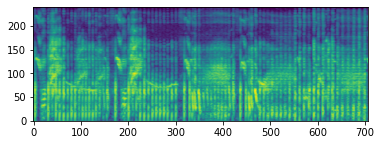

In [61]:
orig_spec = chosen_specs[1][50:]
plt.imshow(orig_spec, origin='lower')

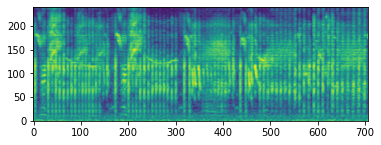

In [62]:
shifted_spec = chosen_specs[1][:-50]
plt.imshow(shifted_spec, origin='lower')

In [45]:
np.mean(np.square(orig_spec-shifted_spec))

0.0026614913

In [10]:
np.sqrt(np.mean(np.square(orig_spec-shifted_spec)))

0.05158964

In [53]:
def spec_gen(spec, mse):
    h, w = spec.shape
    spec = spec.reshape(1, h*w)[0]
    sigma = np.std(mse)
    rand_spec = []
    residual=0
    mean_residual=0
    peppers = []
    for i in range(h*w):
        if mean_residual<0.001:
            rand_spec.append(-1)
            peppers.append(i)
        else:
            rand_spec.append(spec[i])
        residual+=(np.square(rand_spec[i]-spec[i])-np.square(mse))
        mean_residual=residual/(i+1)
#         print(mean_residual)
    if mean_residual>0.003:
        rand_spec[peppers[-1]]=spec[peppers[-1]]
        
    
    
#     rand_spec = np.array([spec[i]+random.normalvariate(0, sigma) for i in range(h*w)])
    
#     pluses = spec-rand_spec>0
#     minuses = spec-rand_spec<0
#     rand_mse = rmse(spec, rand_spec)
#     mse_diff = rand_mse-mse
#     print(mse_diff)
#     while abs(mse_diff)>0.005:
#         shift = abs(random.uniform(0, abs(mse_diff)))
#         rand_spec = np.array([spec[i]+pluses[i]*shift-minuses[i]*shift for i in range(h*w)])
#         pluses = spec-rand_spec>0
#         minuses = spec-rand_spec<0
#         rand_mse = rmse(spec, rand_spec)
#         mse_diff = rand_mse-mse
#         print(mse_diff)
    return np.array(rand_spec).reshape(h, w)

In [54]:
rand_spec = spec_gen(orig_spec, 0.0515)

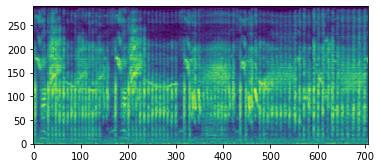

In [55]:
plt.imshow(rand_spec, origin='lower')

## We randomly choose 10 spectrograms, shift each spectrogram by 1~h/2 slices, where h is the total height (number of spectral slices)

In [41]:
chosen_specs = random.sample(spec_list, 10)

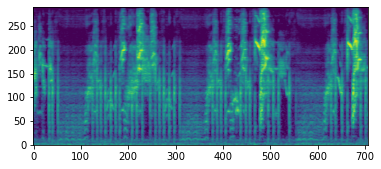

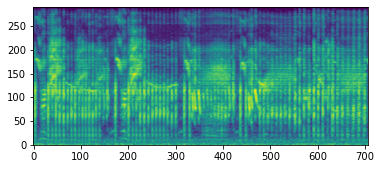

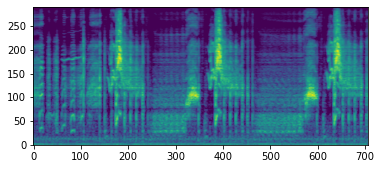

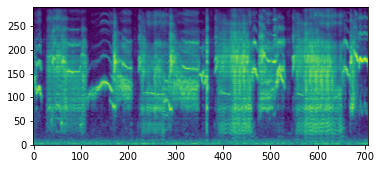

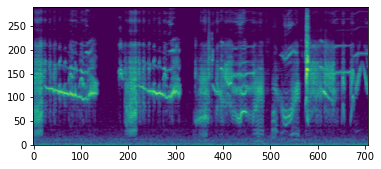

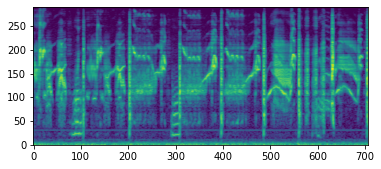

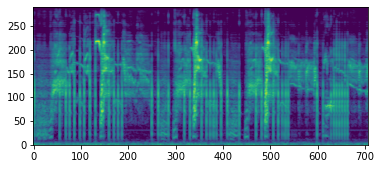

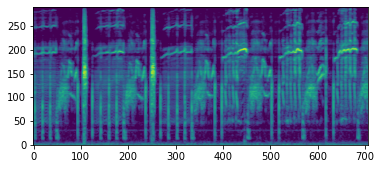

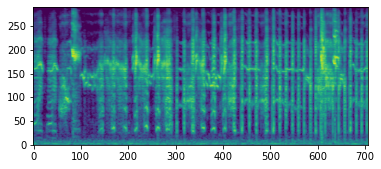

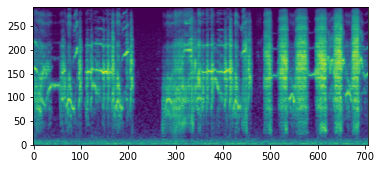

In [43]:
for spec in chosen_specs:
    plt.figure()
    plt.imshow(spec, origin='lower')

In [44]:
pickle.dump(chosen_specs, open('/mnt/cube/kai/results/perceptual_loss/10_specs.p', 'wb'))

In [14]:
chosen_specs = pickle.load(open('/mnt/cube/kai/results/perceptual_loss/10_specs.p', 'rb'))

In [43]:
M = np.array([[ 5 , 1 ,1 , 5,  5],
[5, 1,  2, 4,  5],
[1 ,5, 4, 2 , 3]])

In [44]:
M_u = M.mean(axis=0)
item_mean_subtracted = M - M_u[None,:]

In [45]:
item_mean_subtracted

array([[ 1.33333333, -1.33333333, -1.33333333,  1.33333333,  0.66666667],
       [ 1.33333333, -1.33333333, -0.33333333,  0.33333333,  0.66666667],
       [-2.66666667,  2.66666667,  1.66666667, -1.66666667, -1.33333333]])

In [49]:
distance.cosine(M[0], M[1])

0.012701850133675308

In [48]:
distance.cosine(item_mean_subtracted[0], item_mean_subtracted[1])

0.1344215770989028

In [25]:
def adjusted_cosine_distance(v1, v2):
    v_mean = np.mean([v1, v2], axis=0)
    v1_n = v1-v_mean
    v2_n = v2-v_mean
    
#     print(v1_n, v2_n)
    return distance.cosine(v1_n, v2_n)

In [26]:
spec_index_list = []
n_slices_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []

divided_w = w//3
for spec_i, spec in enumerate(chosen_specs):
    for i in range(3):  #divide into 3 slices
        orig_spec = spec[:, divided_w*i:divided_w*(i+1)]
        for n_slices in range(h//2):  # number of slices to extract
#                 permuted_spec = slice_shift(orig_spec, n_slices)
            
            top_spec = orig_spec[n_slices:, :]
            bottom_spec = orig_spec[:h-n_slices, :]
            orig_3d = np.stack([bottom_spec, bottom_spec, bottom_spec], axis = 2)
            permuted_3d = np.stack([top_spec, top_spec, top_spec], axis = 2)

            orig_features = np.squeeze(feature_extractor.predict(np.expand_dims(orig_3d, axis=0)))
            permuted_features = np.squeeze(feature_extractor.predict(np.expand_dims(permuted_3d, axis=0)))

            spec_index_list.append(spec_i*3+i)
            n_slices_list.append(n_slices)
            feature_rmse_list.append(rmse(orig_features, permuted_features))
            feature_cosine_list.append(adjusted_cosine_distance(orig_features, permuted_features))
            spec_rmse_list.append(rmse(orig_3d, permuted_3d))

            if n_slices%50==0:
                paragraph_print(f'>>{n_slices}', separation='>')
                
    paragraph_print(f'Done with {spec_i}', separation='*')

>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 0
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [27]:
shifted_df = pd.DataFrame()
shifted_df['spec'] = spec_index_list
shifted_df['n_slices'] = n_slices_list
shifted_df['feature_rmse'] = feature_rmse_list
shifted_df['feature_cosine'] = feature_cosine_list
shifted_df['spec_rmse'] = spec_rmse_list

In [13]:
shifted_df = pickle.load(open('/mnt/cube/kai/results/perceptual_loss/shift_test.p', 'rb'))

In [28]:
shifted_df.head(15)

spec  n_slices  feature_rmse  feature_cosine  spec_rmse
0      0         0      0.000000             NaN   0.000000
1      0         1      0.001219             2.0   0.050809
2      0         2      0.001150             2.0   0.072750
3      0         3      0.007209             2.0   0.084197
4      0         4      0.004461             2.0   0.091640
5      0         5      0.001433             2.0   0.096308
6      0         6      0.003286             2.0   0.099876
7      0         7      0.004013             2.0   0.103388
8      0         8      0.002013             2.0   0.106405
9      0         9      0.001776             2.0   0.108173
10     0        10      0.002773             2.0   0.109953
11     0        11      0.001442             2.0   0.112416
12     0        12      0.002224             2.0   0.115677
13     0        13      0.003249             2.0   0.119042
14     0        14      0.004814             2.0   0.121809

### This is what spectrogram rmse loss looks like regarding number of spectral slices shifted
Notice there is a highly positive y intercept, meaning a slight shift in spectrogram will result in high error

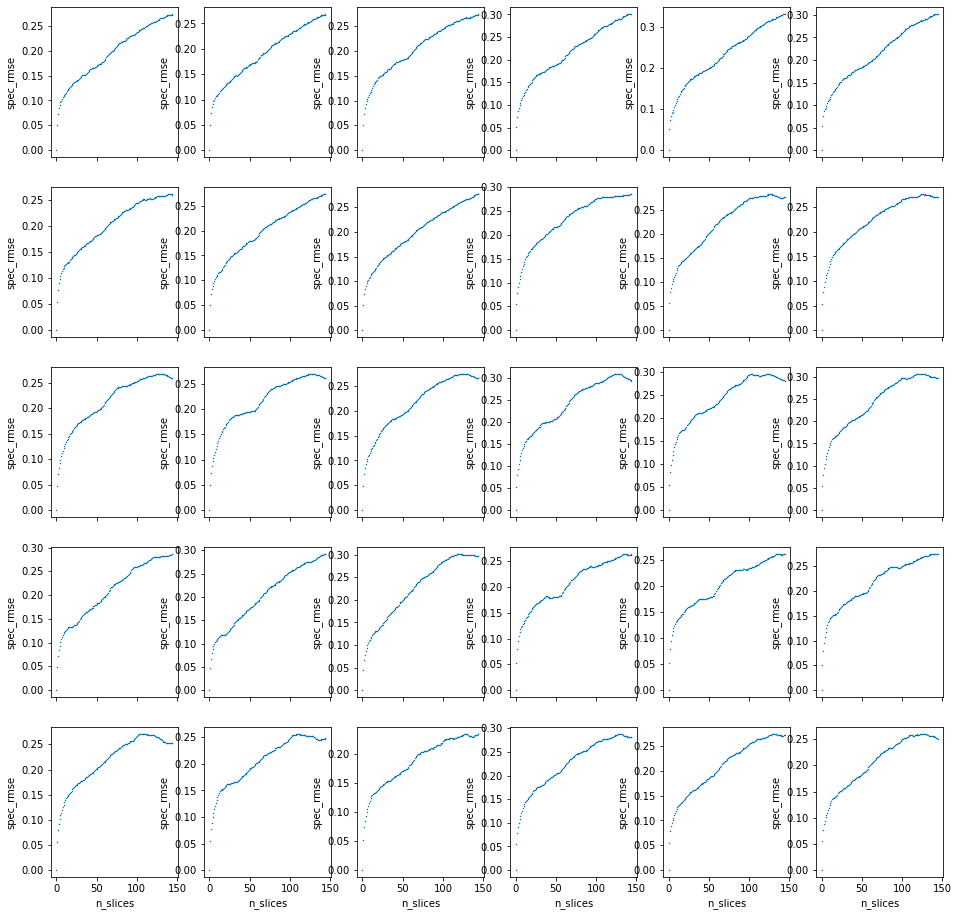

In [6]:
fig, ax = plt.subplots(5, 6, figsize=(16,16), sharex=True)
for i in range(30):
    row = i//6
    col = i%6
    sns.scatterplot(data=shifted_df[shifted_df.spec==i], x='n_slices', y='spec_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])

<AxesSubplot:xlabel='n_slices', ylabel='spec_rmse'>

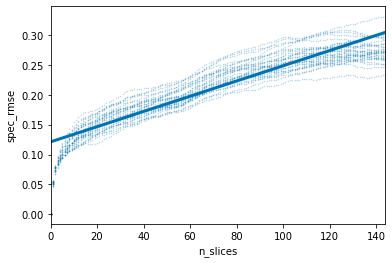

In [32]:
sns.regplot(x='n_slices', y='spec_rmse', data=shifted_df,  
            scatter_kws={'s':0.5, 'alpha':0.2}, line_kws={'linewidth':3})

<AxesSubplot:xlabel='n_slices', ylabel='feature_rmse'>

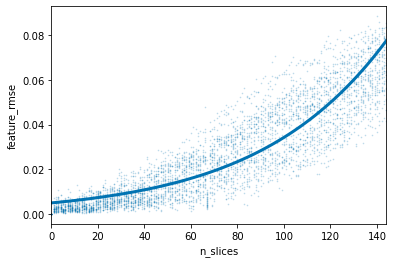

In [36]:
sns.regplot(x='n_slices', y='feature_rmse', data=shifted_df, logistic=True,  
            scatter_kws={'s':0.5, 'alpha':0.2}, line_kws={'linewidth':3})

<AxesSubplot:xlabel='n_slices', ylabel='spec_rmse'>

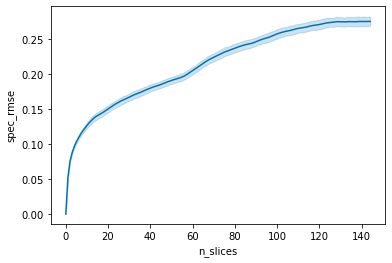

In [20]:
sns.lineplot(x='n_slices', y='spec_rmse', data=shifted_df)

### feature vector rmse vs num spectral slices shifted
Notice there is the y intercept is close to zero, with the slope gradually increasing with increasing x, then plateau at high value, similar to perceptual loss

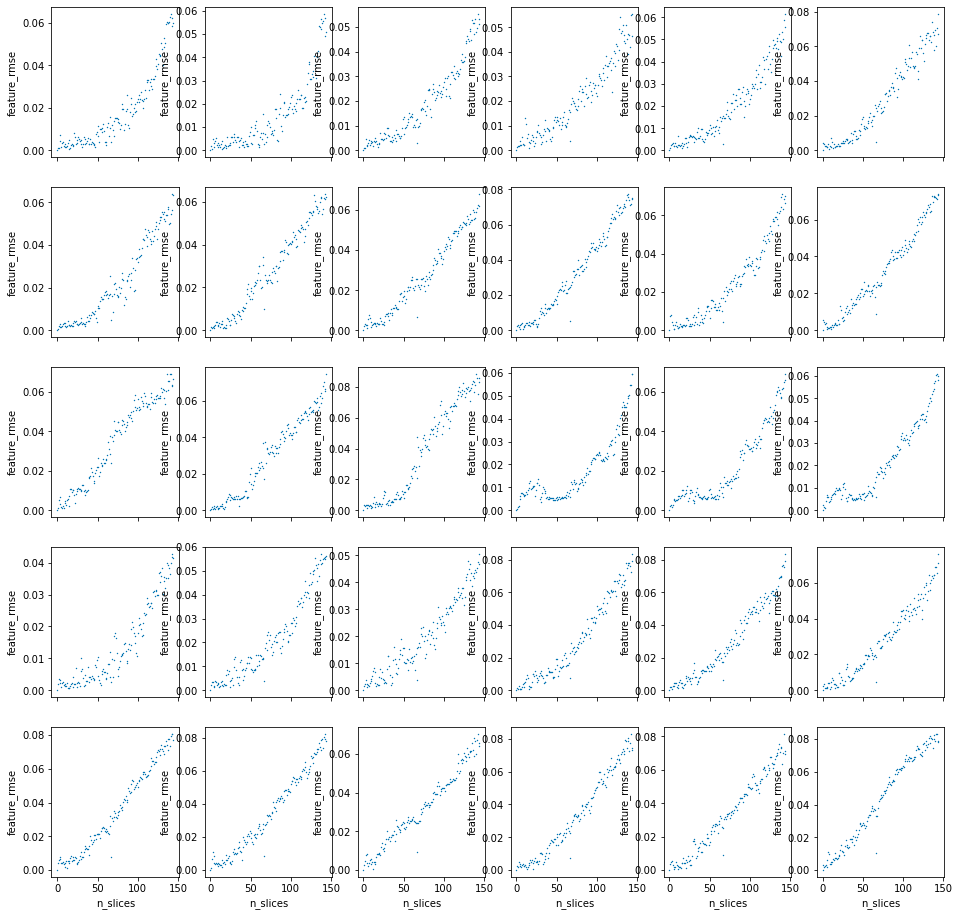

In [80]:
fig, ax = plt.subplots(5, 6, figsize=(16,16), sharex=True)
for i in range(30):
    row = i//6
    col = i%6
    sns.scatterplot(data=shifted_df[shifted_df.spec==i], x='n_slices', y='feature_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])

### feature vector cosine distance vs num spectral slices shifted
Notice there is the y intercept is close to zero, with the slope gradually increasing with increasing x, then plateau at high value, similar to perceptual loss

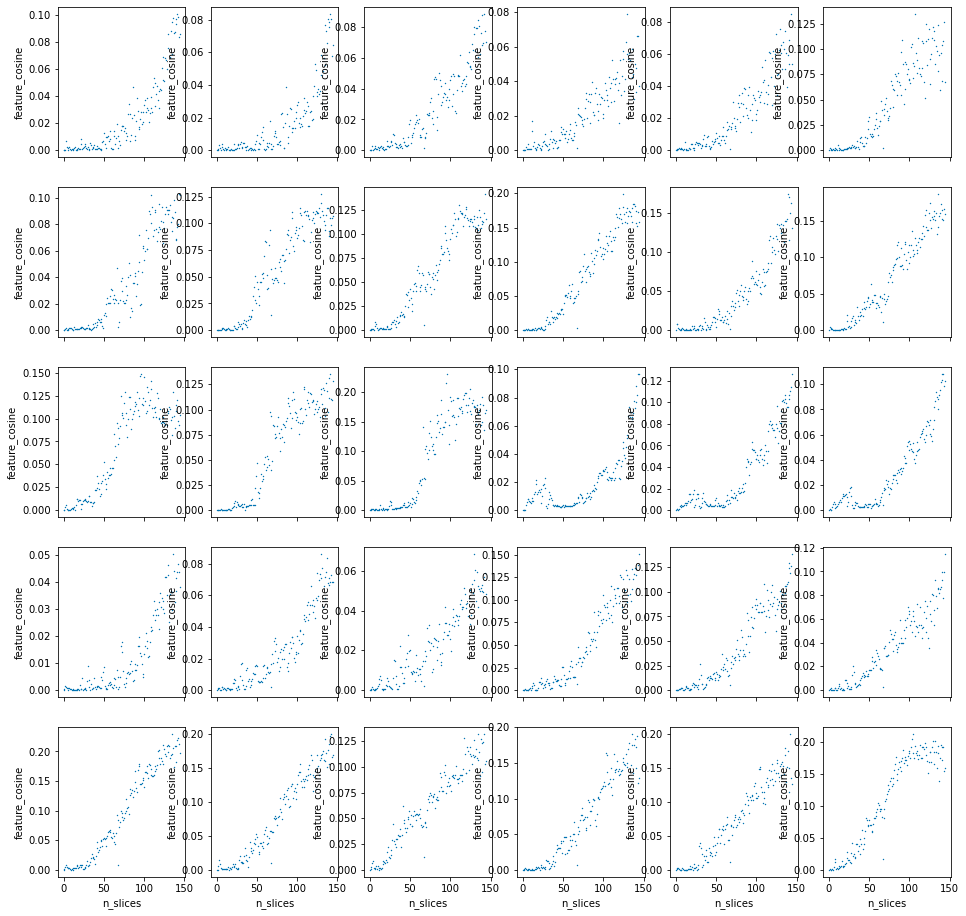

In [81]:
fig, ax = plt.subplots(5, 6, figsize=(16,16), sharex=True)
for i in range(30):
    row = i//6
    col = i%6
    sns.scatterplot(data=shifted_df[shifted_df.spec==i], x='n_slices', y='feature_cosine', 
                s = 2, linewidth = 0, ax=ax[row][col])

In [50]:
shifted_df.to_pickle('/mnt/cube/kai/results/perceptual_loss/shift_test.p')

In [63]:
shifted_df = pickle.load(open('/mnt/cube/kai/results/perceptual_loss/shift_test.p', 'rb'))

# calculate the max errors for normalizing

In [105]:
for spec_i, spec in enumerate(chosen_specs):
    for i in range(3):  #divide into 3 slices
        orig_spec = spec[:, divided_w*i:divided_w*(i+1)]
        silence = np.full((h, divided_w), -1, dtype=float)
        orig_3d = np.stack([orig_spec, orig_spec, orig_spec], axis = 2)
        silence_3d = np.stack([silence, silence, silence], axis = 2)
        orig_features = np.squeeze(feature_extractor.predict(np.expand_dims(orig_3d, axis=0)))
        silence_features = np.squeeze(feature_extractor.predict(np.expand_dims(silence_3d, axis=0)))
#         print(rmse(orig_features, silence_features))
        print(max(orig_features))

0.26554462
0.26688656
0.2700824
0.25059012
0.25529897
0.24823645
0.2670505
0.26456958
0.25852263
0.26339167
0.2531397
0.25024143
0.27228725
0.2810903
0.2745361
0.27106234
0.2686834
0.27193993
0.27254903
0.27059108
0.27005085
0.27208954
0.2735335
0.2769209
0.26279077
0.26661667
0.26337188
0.26893407
0.25452125
0.25754344


# if we pad instead of truncate

In [127]:
spec_index_list = []
n_slices_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []

divided_w = w//3
for spec_i, spec in enumerate(chosen_specs):
    for i in range(3):  #divide into 3 slices
        orig_spec = spec[:, divided_w*i:divided_w*(i+1)]
        for n_slices in range(15):  # number of slices to extract
#                 permuted_spec = slice_shift(orig_spec, n_slices)
            blank_spec = np.full((n_slices+1, divided_w), -1, dtype=float)
            top_spec = np.vstack((blank_spec, orig_spec))
            bottom_spec = np.vstack((orig_spec, blank_spec))
            top_3d = np.stack([top_spec, top_spec, top_spec], axis = 2)
            bottom_3d = np.stack([bottom_spec, bottom_spec, bottom_spec], axis = 2)

            top_features = np.squeeze(feature_extractor.predict(np.expand_dims(top_3d, axis=0)))
            bottom_features = np.squeeze(feature_extractor.predict(np.expand_dims(bottom_3d, axis=0)))

            spec_index_list.append(spec_i*3+i)
            n_slices_list.append(n_slices+1)
            feature_rmse_list.append(rmse(top_features, bottom_features))
            feature_cosine_list.append(distance.cosine(top_features, bottom_features))
            spec_rmse_list.append(rmse(top_3d, bottom_3d))

            if n_slices%50==0:
                paragraph_print(f'>>{n_slices}', separation='>')
                
    paragraph_print(f'Done with {spec_i}', separation='*')

>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 0
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 1
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 2
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 3
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [128]:
TB_df = pd.DataFrame()
TB_df['spec'] = spec_index_list
TB_df['n_slices'] = n_slices_list
TB_df['feature_rmse'] = feature_rmse_list
TB_df['feature_cosine'] = feature_cosine_list
TB_df['spec_rmse'] = spec_rmse_list

In [129]:
TB_df_melt = pd.melt(TB_df, id_vars=['spec', 'n_slices'], 
                     value_vars=['feature_cosine','spec_rmse'],
                     var_name='metric')

In [130]:
TB_df_melt['metric'] = TB_df_melt['metric'].apply(lambda x: name_dict[x])

Text(0.5, 1.0, 'Shifting in frequency domain')

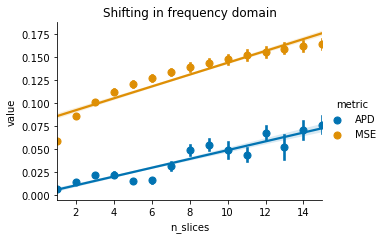

In [135]:
g = sns.lmplot(x='n_slices', y='value', data=TB_df_melt, hue='metric', x_estimator=np.mean, height=3, aspect=1.5,
           legend=True
            )
plt.title('Shifting in frequency domain')

In [132]:
TB_df_melt[TB_df_melt.n_slices==1].groupby('metric')['value'].describe()

count      mean       std       min       25%       50%       75%  \
metric                                                                      
APD      30.0  0.006322  0.002918  0.000705  0.004267  0.005794  0.008153   
MSE      30.0  0.058860  0.003129  0.053608  0.057017  0.058054  0.059831   

             max  
metric            
APD     0.013360  
MSE     0.065604

In [133]:
TB_df_melt.groupby('metric')['value'].describe()

count      mean       std       min       25%       50%       75%  \
metric                                                                      
APD     450.0  0.039408  0.028551  0.000705  0.016854  0.029906  0.056419   
MSE     450.0  0.131152  0.031726  0.053608  0.114262  0.135205  0.152964   

             max  
metric            
APD     0.142542  
MSE     0.191401

In [146]:
TB_MSE_n_slices = TB_df_melt[TB_df_melt.metric=='MSE'].n_slices.values.reshape(-1, 1)
TB_MSE_val = TB_df_melt[TB_df_melt.metric=='MSE'].value.values.reshape(-1, 1)

In [148]:
TB_APD_n_slices = TB_df_melt[TB_df_melt.metric=='APD'].n_slices.values.reshape(-1, 1)
TB_APD_val = TB_df_melt[TB_df_melt.metric=='APD'].value.values.reshape(-1, 1)

In [161]:
TB_MSE = LinearRegression()

In [162]:
TB_MSE.fit(TB_MSE_n_slices, TB_MSE_val)

LinearRegression()

In [163]:
TB_MSE.score(TB_MSE_n_slices, TB_MSE_val)

0.773251165709715

In [164]:
TB_MSE.coef_

array([[0.00644989]])

In [166]:
TB_APD = LinearRegression()
TB_APD.fit(TB_APD_n_slices, TB_APD_val)
print(TB_APD.score(TB_APD_n_slices, TB_APD_val))
print(TB_APD.coef_)

0.5246666892874068
[[0.00478126]]


# horizontal shift

In [114]:
spec_index_list = []
n_slices_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []

divided_w = w//3
for spec_i, spec in enumerate(chosen_specs):
    for i in range(3):  #divide into 3 slices
        orig_spec = spec[:, divided_w*i:divided_w*(i+1)]
        for n_slices in range(15):  # number of slices to extract
#                 permuted_spec = slice_shift(orig_spec, n_slices)
            blank_spec = np.full((h, n_slices+1), -1, dtype=float)
            left_spec = np.hstack((blank_spec, orig_spec))
            right_spec = np.hstack((orig_spec, blank_spec))
            left_3d = np.stack([left_spec, left_spec, left_spec], axis = 2)
            right_3d = np.stack([right_spec, right_spec, right_spec], axis = 2)

            left_features = np.squeeze(feature_extractor.predict(np.expand_dims(left_3d, axis=0)))
            right_features = np.squeeze(feature_extractor.predict(np.expand_dims(right_3d, axis=0)))

            spec_index_list.append(spec_i*3+i)
            n_slices_list.append(n_slices+1)
            feature_rmse_list.append(rmse(left_features, right_features))
            feature_cosine_list.append(distance.cosine(left_features, right_features))
            spec_rmse_list.append(rmse(left_3d, right_3d))

            if n_slices%50==0:
                paragraph_print(f'>>{n_slices}', separation='>')
                
    paragraph_print(f'Done with {spec_i}', separation='*')

>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 0
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 1
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 2
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 3
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [115]:
LR_df = pd.DataFrame()
LR_df['spec'] = spec_index_list
LR_df['n_slices'] = n_slices_list
LR_df['feature_rmse'] = feature_rmse_list
LR_df['feature_cosine'] = feature_cosine_list
LR_df['spec_rmse'] = spec_rmse_list

In [116]:
LR_df_melt = pd.melt(LR_df, id_vars=['spec', 'n_slices'], 
                     value_vars=['feature_cosine','spec_rmse'],
                     var_name='metric')

In [117]:
LR_df_melt[LR_df_melt.n_slices==1].groupby('metric')['value'].describe()

count      mean       std       min       25%       50%  \
metric                                                                    
feature_cosine   30.0  0.000213  0.000365  0.000008  0.000053  0.000109   
spec_rmse        30.0  0.060276  0.010217  0.044719  0.052085  0.059997   

                     75%       max  
metric                              
feature_cosine  0.000170  0.001790  
spec_rmse       0.067112  0.083476

In [118]:
LR_df_melt.groupby('metric')['value'].describe()

count      mean       std       min       25%       50%  \
metric                                                                    
feature_cosine  450.0  0.000593  0.000865  0.000008  0.000087  0.000234   
spec_rmse       450.0  0.175285  0.051064  0.044719  0.148928  0.185232   

                     75%       max  
metric                              
feature_cosine  0.000713  0.006081  
spec_rmse       0.208100  0.317041

In [119]:
name_dict = {'feature_cosine': 'APD', 'spec_rmse': 'MSE'}

In [120]:
LR_df_melt['metric'] = LR_df_melt['metric'].apply(lambda x: name_dict[x])

In [121]:
LR_APD = LR_df_melt[LR_df_melt.metric=='APD']['value'].values.tolist()

In [122]:
LR_APD

[3.6597251892089844e-05,
 0.00015211105346679688,
 0.0001971125602722168,
 6.592273712158203e-05,
 0.0003641843795776367,
 0.00026297569274902344,
 0.00012886524200439453,
 0.00011521577835083008,
 0.00017589330673217773,
 0.0001647472381591797,
 0.0003547072410583496,
 0.0005522370338439941,
 0.00048029422760009766,
 0.0008643269538879395,
 0.00020998716354370117,
 2.872943878173828e-05,
 2.294778823852539e-05,
 0.00024396181106567383,
 3.170967102050781e-05,
 0.00016123056411743164,
 0.00014895200729370117,
 5.84721565246582e-05,
 3.892183303833008e-05,
 4.363059997558594e-05,
 0.00022280216217041016,
 0.00011968612670898438,
 3.361701965332031e-05,
 1.8537044525146484e-05,
 0.00011289119720458984,
 0.00015372037887573242,
 0.00024884939193725586,
 3.8504600524902344e-05,
 9.08970832824707e-05,
 1.341104507446289e-05,
 0.0001685619354248047,
 9.638071060180664e-05,
 5.7637691497802734e-05,
 4.0411949157714844e-05,
 0.00046181678771972656,
 7.843971252441406e-05,
 0.000296652317047119

In [123]:
from scipy import stats

t_value,p_value=stats.ttest_1samp(LR_APD, 0)

In [124]:
t_value

14.556963323880836

In [125]:
p_value

1.344682327791063e-39

Text(0.5, 1.0, 'Shifting in time domain')

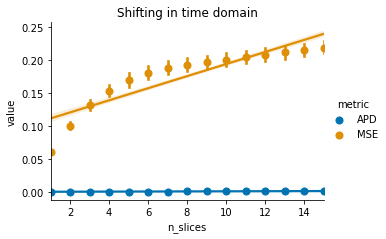

In [126]:
g = sns.lmplot(x='n_slices', y='value', data=LR_df_melt, hue='metric', x_estimator=np.mean, height=3, aspect=1.5,
           legend=True
            )
plt.title('Shifting in time domain')

In [44]:
LR_df.to_pickle('/mnt/cube/kai/results/perceptual_loss/LR_shift_pad.p')

# Second we test how permuting a small number of slices affect loss
A real life example would be noise in either the spectral or temporal domain

In [168]:
def random_insert(spec, n_slices, axis=0, return_distance=False):
    '''
    The function randomly choose n_slices from the spectrogram, and randomly shuffles their location in the spectrogram,
    all other slices shift according to the position of the new slices
    
    spec needs to be 2D, not a 3D image
    '''
    assert len(spec.shape)==2
    if axis==1:
        spec = spec.T
        
    n_total = spec.shape[0]
    left_indeces = list(range(n_total))
    extract_indeces = random.sample(left_indeces, n_slices)
    for index in extract_indeces:
        left_indeces.remove(index)
        
    shifted_distance = []
    for index in extract_indeces:
        n_left = len(left_indeces)
        insert_i = random.randrange(n_left+1)
        shifted_distance.append(index-insert_i)
        left_indeces.insert(insert_i, index)
    
    permuted_distance = np.sqrt(np.sum(np.square(shifted_distance))/n_total)
    final_indeces = left_indeces
    
    assert len(final_indeces) == n_total
    
    new_spec = spec[final_indeces, :]
    
    if axis==1:
        new_spec = new_spec.T
    
    if return_distance:
        return new_spec, permuted_distance
    else:
        return new_spec

In [179]:
def add_noise(spec):
    '''
    The function adds noise to spectrograms
    
    spec needs to be 2D, not a 3D image
    '''
    assert len(spec.shape)==2
    new_spec = spec+np.random.normal(0, 0.2, spec.shape)
    new_spec[new_spec<-1]=-1
    new_spec[new_spec>0]=0
    return new_spec

Original spectrogram

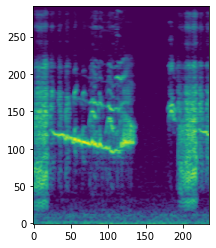

In [180]:
orig_spec = chosen_specs[4][:,:235]
plt.imshow(orig_spec, origin='lower')

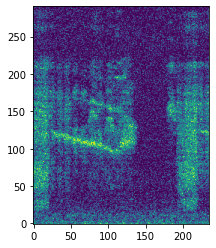

In [181]:
test = add_noise(orig_spec)
plt.imshow(test, origin='lower')

Permute 1 spectral slice

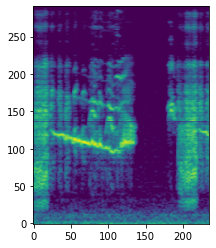

In [171]:
permuted_spec= random_insert(orig_spec, 1)
plt.imshow(permuted_spec, origin='lower')

Permute 10 slices

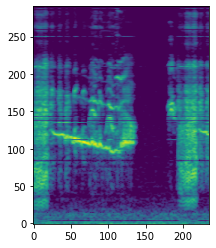

In [172]:
permuted_spec, permuted_distance = random_insert(orig_spec, 10, return_distance=True)
plt.imshow(permuted_spec, origin='lower')

Permute 100

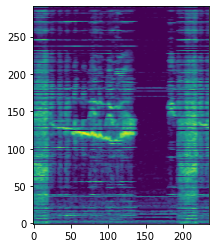

In [173]:
permuted_spec, permuted_distance = random_insert(orig_spec, 100, return_distance=True)
plt.imshow(permuted_spec, origin='lower')

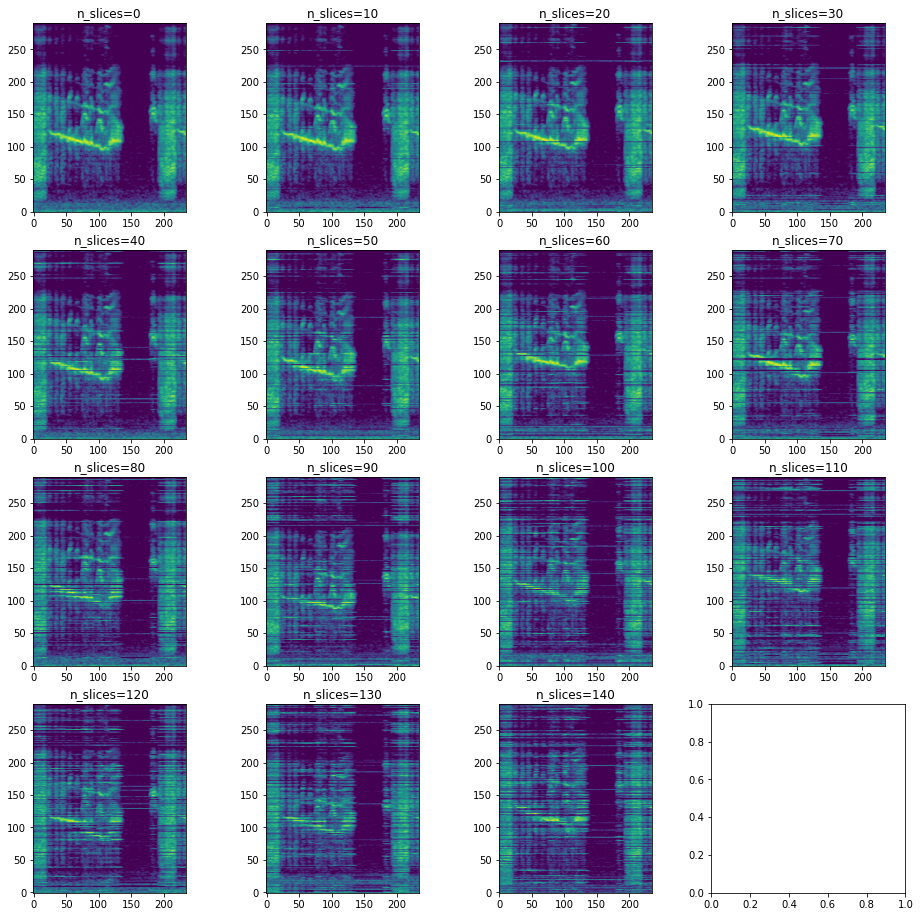

In [174]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in np.arange(0,h//2, 10):
    row = i//10//4
    col = i//10%4
    permuted_spec = random_insert(orig_spec, i)
    ax[row][col].imshow(permuted_spec, origin='lower')
    ax[row][col].set_title(f'n_slices={i}')

In [55]:
spec_index_list = []
n_slices_list = []
iter_list = []
permuted_distance_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []

divided_w = w//3
for spec_i, spec in enumerate(chosen_specs):
    for i in range(3):  #divide into 3 slices
        orig_spec = spec[:, divided_w*i:divided_w*(i+1)]
        for n_slices in range(h//2):  # number of slices to extract
            for rep in range(10):  # each repeat 10 times
                permuted_spec, permuted_distance = random_insert(orig_spec, n_slices, return_distance=True)
                orig_3d = np.stack([orig_spec, orig_spec, orig_spec], axis = 2)
                permuted_3d = np.stack([permuted_spec, permuted_spec, permuted_spec], axis = 2)
                
                orig_features = np.squeeze(feature_extractor.predict(np.expand_dims(orig_3d, axis=0)))
                permuted_features = np.squeeze(feature_extractor.predict(np.expand_dims(permuted_3d, axis=0)))
                
                spec_index_list.append(spec_i*3+i)
                n_slices_list.append(n_slices)
                iter_list.append(rep)
                feature_rmse_list.append(rmse(orig_features, permuted_features))
                feature_cosine_list.append(distance.cosine(orig_features, permuted_features))
                permuted_distance_list.append(permuted_distance)
                spec_rmse_list.append(rmse(orig_3d, permuted_3d))
                
            if n_slices%50==0:
                paragraph_print(f'>>{n_slices}', separation='>')
                
    paragraph_print(f'Done with {spec_i}', separation='*')

>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 0
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>50
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [56]:
permute_df = pd.DataFrame()
permute_df['spec'] = spec_index_list
permute_df['n_slices'] = n_slices_list
permute_df['iter'] = iter_list
permute_df['feature_rmse'] = feature_rmse_list
permute_df['feature_cosine'] = feature_cosine_list
permute_df['permutation_distance'] = permuted_distance_list
permute_df['spec_rmse'] = spec_rmse_list

In [86]:
permute_df.describe()

spec      n_slices          iter  feature_rmse  feature_cosine  \
count  87300.000000  87300.000000  87300.000000  87300.000000    87300.000000   
mean      14.500000    145.000000      4.500000      0.032810        0.143032   
std        8.655491     84.004449      2.872298      0.016894        0.106147   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%        7.000000     72.000000      2.000000      0.024146        0.080808   
50%       14.500000    145.000000      4.500000      0.029384        0.121476   
75%       22.000000    218.000000      7.000000      0.035560        0.166311   
max       29.000000    290.000000      9.000000      0.105912        0.657565   

       permutation_distance     spec_rmse  
count          87300.000000  87300.000000  
mean              78.218211      0.159224  
std               30.103003      0.046054  
min                0.000000      0.000000  
25%               56.473384      0.129761  
50%               80.157834      0.165214  
75%              102.745603      0.194064  
max              136.094646      0.251819

In [57]:
permute_df.to_pickle('/mnt/cube/kai/results/perceptual_loss/permute_test.p')

In [5]:
permute_df = pickle.load(open('/mnt/cube/kai/results/perceptual_loss/permute_test.p', 'rb'))

Text(0.5, 1.0, 'permutation distance vs num slices')

<Figure size 576x432 with 0 Axes>

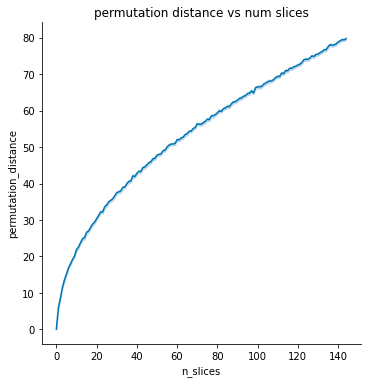

In [58]:
plt.figure(figsize=(8,6))
sns.relplot(data=permute_df, x='n_slices', y='permutation_distance', kind='line')
plt.title('permutation distance vs num slices')

Text(0.5, 1.0, 'feature cosine distance vs num slices')

<Figure size 576x432 with 0 Axes>

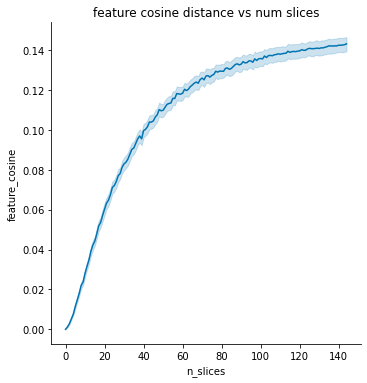

In [59]:
plt.figure(figsize=(8,6))
sns.relplot(data=permute_df, x='n_slices', y='feature_cosine', kind='line')
plt.title('feature cosine distance vs num slices')

Text(0.5, 1.0, 'feature rmse vs num slices')

<Figure size 576x432 with 0 Axes>

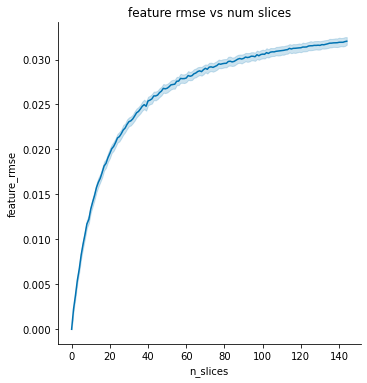

In [60]:
plt.figure(figsize=(8,6))
sns.relplot(data=permute_df, x='n_slices', y='feature_rmse', kind='line')
plt.title('feature rmse vs num slices')

Text(0.5, 1.0, 'spectrogram rmse vs num slices')

<Figure size 576x432 with 0 Axes>

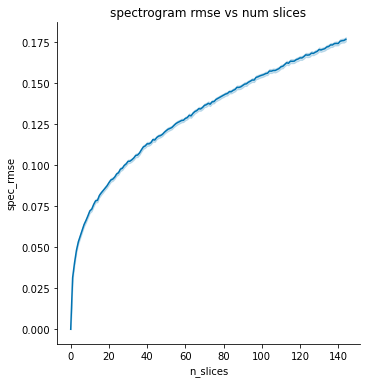

In [61]:
plt.figure(figsize=(8,6))
sns.relplot(data=permute_df, x='n_slices', y='spec_rmse', kind='line')
plt.title('spectrogram rmse vs num slices')

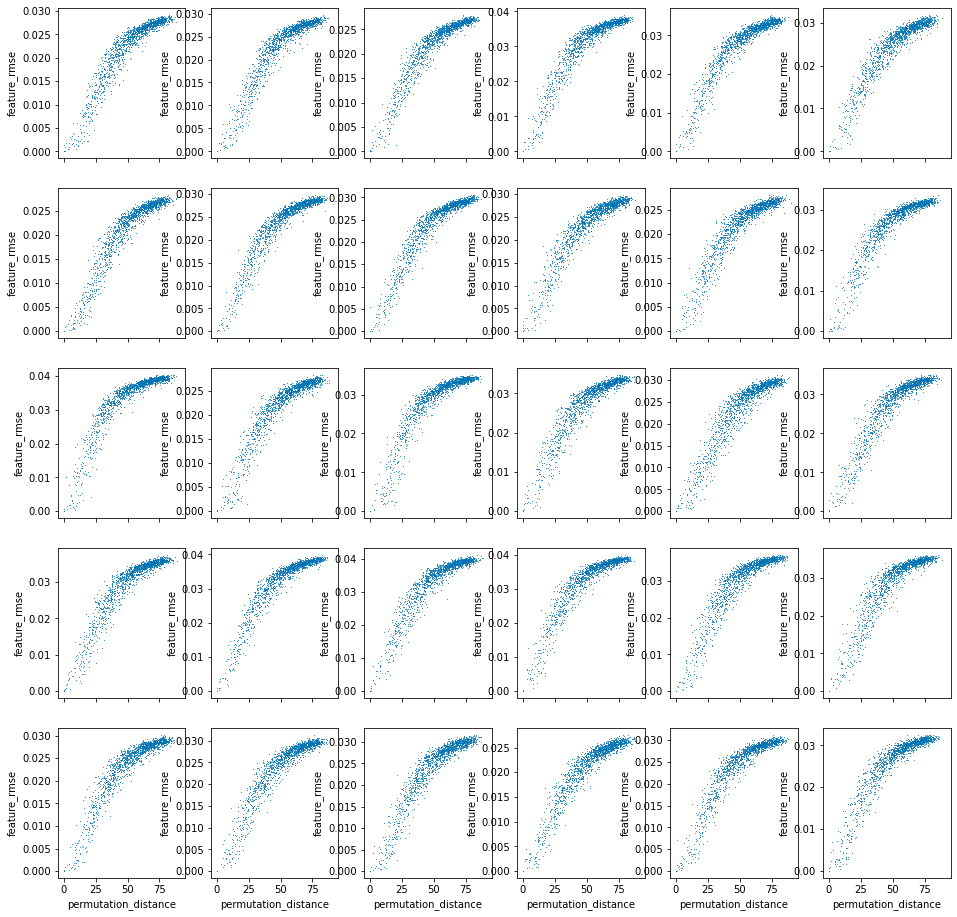

In [62]:
fig, ax = plt.subplots(5, 6, figsize=(16,16), sharex=True)
for i in range(30):
    row = i//6
    col = i%6
    sns.scatterplot(data=permute_df[(permute_df.spec==i) & (permute_df.n_slices<145)], x='permutation_distance', 
                    y='feature_rmse', 
                    s = 1, linewidth = 0, ax=ax[row][col])

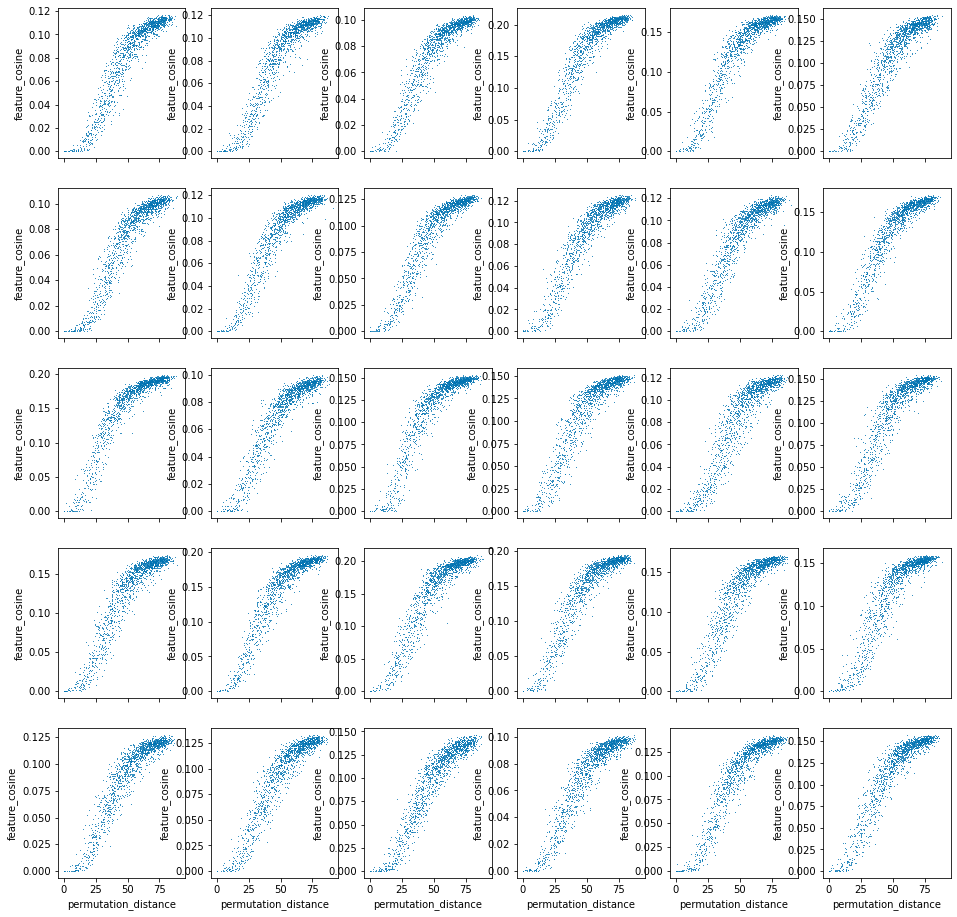

In [63]:
fig, ax = plt.subplots(5, 6, figsize=(16,16), sharex=True)
for i in range(30):
    row = i//6
    col = i%6
    sns.scatterplot(data=permute_df[(permute_df.spec==i) & (permute_df.n_slices<145)], x='permutation_distance', 
                    y='feature_cosine', 
                    s = 1, linewidth = 0, ax=ax[row][col])

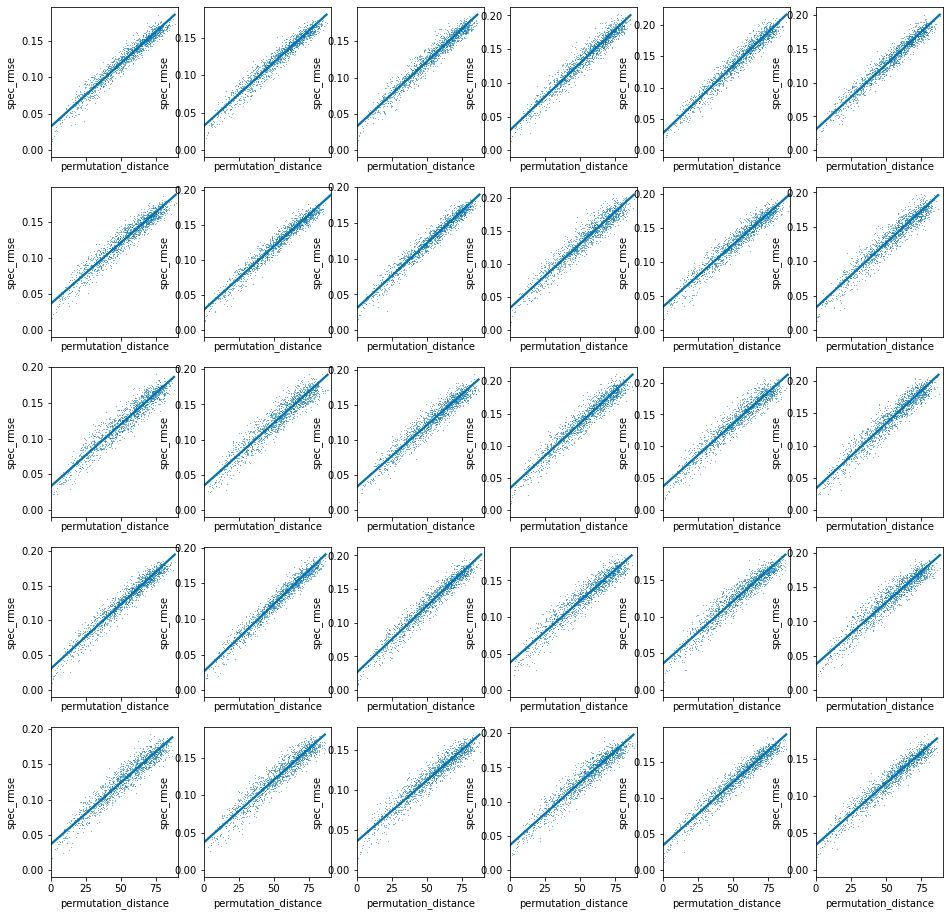

In [64]:
fig, ax = plt.subplots(5, 6, figsize=(16,16), sharex=True)
for i in range(30):
    row = i//6
    col = i%6
    sns.regplot(data=permute_df[(permute_df.spec==i) & (permute_df.n_slices<145)], x='permutation_distance', y='spec_rmse', 
                scatter_kws={'s':0.5, 'linewidth':0}, ax=ax[row][col])

In [26]:
def adjusted_sigmoid(A):
    def sigmoid(x, x0, k):
        y = A / (1 + np.exp(-k*(x-x0)))
        return y
    return sigmoid

In [24]:
from scipy.optimize import curve_fit

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

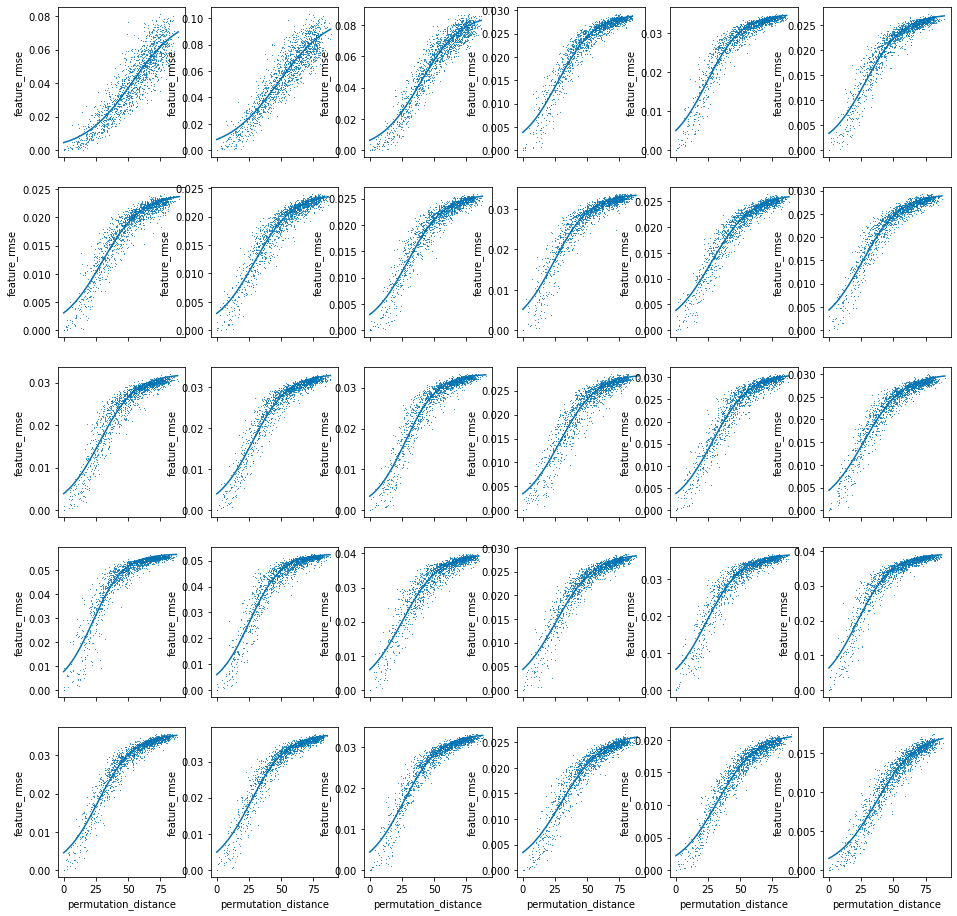

In [27]:
fig, ax = plt.subplots(5, 6, figsize=(16,16), sharex=True)
for i in range(30):
    row = i//6
    col = i%6
    spec_df = permute_df[(permute_df.spec==i) & (permute_df.n_slices<145)].reset_index(drop=True)
    sns.scatterplot(data=spec_df, x='permutation_distance', y='feature_rmse', 
                s = 1, linewidth = 0, ax=ax[row][col])
    sigmoid = adjusted_sigmoid(spec_df.feature_rmse.values.max())
    popt, _ = curve_fit(sigmoid, spec_df.permutation_distance, spec_df.feature_rmse)
    fit_x = np.linspace(spec_df.permutation_distance.values.min(), spec_df.permutation_distance.values.max(), 250)
    fit_y = sigmoid(fit_x, *popt)
    sns.lineplot(fit_x, fit_y, ax=ax[row][col])

# noise-vocoded vocalizations

In [ ]:
spec_index_list = []
n_slices_list = []
iter_list = []
permuted_distance_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []

divided_w = w//3
for spec_i, spec in enumerate(chosen_specs):
    for i in range(3):  #divide into 3 slices
        orig_spec = spec[:, divided_w*i:divided_w*(i+1)]
        for n_slices in range(h//2):  # number of slices to extract
            for rep in range(10):  # each repeat 10 times
                permuted_spec, permuted_distance = random_insert(orig_spec, n_slices, return_distance=True)
                orig_3d = np.stack([orig_spec, orig_spec, orig_spec], axis = 2)
                permuted_3d = np.stack([permuted_spec, permuted_spec, permuted_spec], axis = 2)
                
                orig_features = np.squeeze(feature_extractor.predict(np.expand_dims(orig_3d, axis=0)))
                permuted_features = np.squeeze(feature_extractor.predict(np.expand_dims(permuted_3d, axis=0)))
                
                spec_index_list.append(spec_i*3+i)
                n_slices_list.append(n_slices)
                iter_list.append(rep)
                feature_rmse_list.append(rmse(orig_features, permuted_features))
                feature_cosine_list.append(distance.cosine(orig_features, permuted_features))
                permuted_distance_list.append(permuted_distance)
                spec_rmse_list.append(rmse(orig_3d, permuted_3d))
                
            if n_slices%50==0:
                paragraph_print(f'>>{n_slices}', separation='>')
                
    paragraph_print(f'Done with {spec_i}', separation='*')

# What's next?

## (Part 1) fine tune feature extraction model on Michael's data
### Prelim task:
Cluster/correlate extracted features vs response time (no model training needed)
### Inputs: 
stimuli
### Outputs: 
response time?
### Questions to address:
A. are all stimuli the same length (need to test similarity between two renditions of the same stim, long vs short)

B. how are stimuli chosen (any categories used? Maybe we can do a semi-supervised training with category labels as pseudo label and rsponse time as true label?)

## (Part 2) test perceptual loss vs rmse
What task should we use for this comparison?